## ML Review and Gradient Descent Example

In this notebook, we will solve a simple linear regression problem by gradient descent.  
We will see the effect of the learning rate on the trajectory in parameter space.
We will show how Stochastic Gradient Descent (SGD) differs from the standard version, and the effect of "shuffling" your data during SGD.

In [1]:
# Preliminaries - packages to load

from __future__ import print_function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
%matplotlib inline

## Generate Data from a known distribution
Below we will generate data a known distribution.  
Specifically, the true model is:

$Y = b + \theta_1 X_1 + \theta_2 X_2 + \epsilon$

$X_1$ and $X_2$ have a uniform distribution on the interval $[0,10]$, while `const` is a vector of ones (representing the intercept term).

We set actual values for $b$ ,$\theta_1$, and $\theta_2$

Here $b=1.5$, $\theta_1=2$, and $\theta_2=5$

We then generate a vector of $y$-values according to the model and put the predictors together in a "feature matrix" `x_mat`

In [2]:
# set seed for consistent random values
np.random.seed(42)

# assume these are the parameters we learned
err_coeff = 1.5
W = np.array([2, 5])

# generate the dataset feature values # 1000 instances with 2 columns
X = np.random.uniform(0, 10, (1000, 2))
# calculate the output
y = np.dot(X, W) + err_coeff

print(W)
print(X[:10])
print(y[:10])

[2 5]
[[1.24089281 6.0260189 ]
 [4.78174402 8.34655322]
 [0.11384211 1.62208482]
 [3.56271863 5.16554086]
 [1.95736731 9.36606892]
 [9.41376622 0.70686885]
 [3.77219036 1.15882685]
 [4.46585023 3.58595779]
 [4.53297792 3.72722649]
 [2.94032264 8.40249737]]
[34.11188013 52.79625413  9.83810834 34.45314153 52.24507923 23.86187667
 14.83851496 28.36148938 29.20208827 49.39313215]


## Get the "Right" answer directly
In the below cells we solve for the optimal set of coefficients.  Note that even though the true model is given by:

$b=1.5$, $\theta_1=2$, and $\theta_2=5$

The maximum likelihood (least-squares) estimate from a finite data set may be slightly different.

## Exercise:
Solve the problem two ways: 
1. By using the scikit-learn LinearRegression model
2. Using matrix algebra directly via the formula $\theta = (X^T X)^{-1}X^Ty$

Note: The scikit-learn solver may give a warning message, this can be ignored.

In [3]:
# sklearn
model = LinearRegression()
model.fit(X, y)

model.coef_

array([2., 5.])

In [4]:
# matrix algebra
A = np.dot(X.T, X)
B = np.dot(X.T, y)
W_ = np.dot(np.linalg.inv(A), B)
W_

array([2.13233157, 5.12259855])

## Solving by Gradient Descent


For most numerical problems, we don't / can't know the underlying analytical solution. This is because we only arrive at analytical solutions by solving the equations mathematically, with pen and paper. That is more often than not just impossible. Fortunately, we have a way of converging to an approximate solution, by using **Gradient Descent**.


We will explore this very useful method because Neural Networks, along with many other complicated algorithms, are trained using Gradient Descent.  Seeing how gradient descent works on a simple example will build intuition and help us understand some of the nuances around setting the learning rate and other parameters.  We will also explore Stochastic Gradient Descent and compare its behavior to the standard approach.

## Exercise

The next several cells have code to perform (full-batch) gradient descent.  We have omitted some parameters for you to fill in.

1. Pick a learning rate, and a number of iterations, run the code, and then plot the trajectory of your gradient descent.
1. Find examples where the learning rate is too high, too low, and "just right".
1. Look at plots of loss function under these conditions.



In [39]:
# returns history of loss function and weights over each iterations
def gradient_descent(X, y, learning_rate=.01, num_iters=100):
    history_weights = np.zeros((num_iters, 2))
    history_loss = np.zeros(num_iters)
    
    num_records = X.shape[0]
    
    W = np.random.randn(X.shape[1]) # number of features
    bias = 0
    
    for i in range(num_iters):
        y_hat = np.dot(X, W) + bias
        
        # update the weights
        W = W - (1 / num_records) * learning_rate * np.dot(X.T, y_hat - y)
        history_weights[i, ] = W
        
        bias = bias - (learning_rate * np.sum(y_hat - y) / num_records)
        
        # calculate the new loss value
        loss = .5 * num_records * np.sum(np.square(y_hat - y))
        history_loss[i, ] = loss
        
    return W, err_coeff, history_weights, history_loss
        

('weights: ', array([-4.82299392e+14, -4.75971677e+14]))


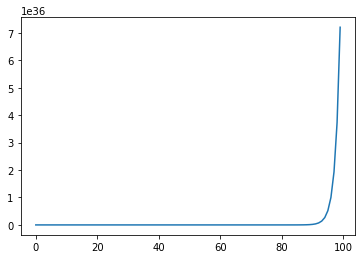

In [40]:
# too high
W_, b, W_hist, loss_hist = gradient_descent(X, y, learning_rate=.04)
print(('weights: ', W_))
plt.plot(loss_hist)

('weights: ', array([-0.02465058, -0.00304459]))


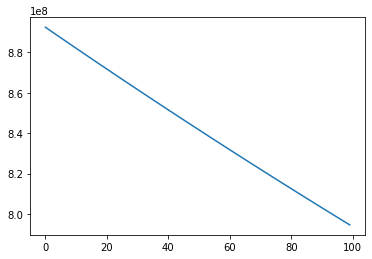

In [41]:
# too low
W_, b, W_hist, loss_hist = gradient_descent(X, y, learning_rate=.00001)
print(('weights: ', W_))
plt.plot(loss_hist)

('weights: ', array([2.06248181, 5.0578276 ]))


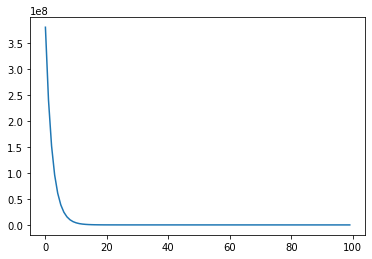

In [42]:
# good learning rate
W_, b, W_hist, loss_hist = gradient_descent(X, y, learning_rate=.0301)
print(('weights: ', W_))
plt.plot(loss_hist)

## Stochastic Gradient Descent
Rather than average the gradients across the whole dataset before taking a step, we will now take a step for every datapoint.  Each step will be somewhat of an "overreaction" but they should average out.  

## Exercise
The below code runs Stochastic Gradient descent, but runs through the data in the same order every time.  

1. Run the code and plot the graphs.  What do you notice?
2. Modify the code so that it randomly re-orders the data.  How do the sample trajectories compare?

In [43]:
def stochastic_gradient_descent(X, y, learning_rate=.01, num_iters=100, sample_size=5, shuffle=False):
    history_weights = np.zeros((num_iters, 2))
    history_loss = np.zeros(num_iters)
    
    num_records = X.shape[0]
    
    W = np.random.randn(X.shape[1])
    bias = 0
    
    # if shuffling
    if shuffle:
        # first columns will be features and last column will be the output (y)
        dataset = np.hstack((X, y.reshape(-1, 1)))
        np.random.shuffle(dataset)
        X = dataset[:, :-1]
        y = dataset[:, -1]
    
    
    
    for i in range(num_iters):
        indexes = np.random.randint(num_records, size=sample_size)
        X_sub = X[indexes]
        y_sub = y[indexes]
        
        w_gradient = np.zeros((sample_size, 2))
        bias_gradient = np.zeros(sample_size)
        
        y_hat = np.dot(X_sub, W) + bias
                  
        W = W - (1 / sample_size) * learning_rate * np.dot(X_sub.T, y_hat - y_sub)
        bias = bias - (learning_rate * np.sum(y_hat - y_sub) / sample_size)
        
        history_weights[i, ] = W
        loss = .5 * sample_size * np.sum(np.square(y_hat - y_sub))
        history_loss[i, ] = loss
            
    
    return W, bias, history_weights, history_loss

Play with the parameters below and observe the trajectory it results in

('weights: ', array([1.82400122, 4.60088604]))


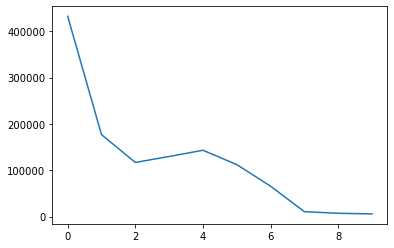

In [46]:
W_, b, W_hist, loss_hist = stochastic_gradient_descent(X, y, learning_rate = .0301, num_iters = 10, sample_size = 25, shuffle=False)
print(('weights: ', W_))
plt.plot(loss_hist)

('weights: ', array([1.78982173, 4.55985655]))


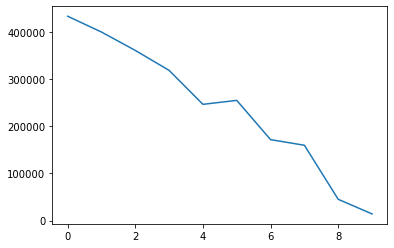

In [47]:
W_, b, W_hist, loss_hist = stochastic_gradient_descent(X, y, learning_rate = .0301, num_iters = 10, sample_size = 25, shuffle=True)
print(('weights: ', W_))
plt.plot(loss_hist)